##### 1. Import Libraries and Datasets

In [33]:
# Import libraries
import pandas as pd 
import numpy as np
import openpyxl

In [34]:
# Import datasets
raw_data1 = pd.read_excel("./data/LexisNexis_cleaned.xlsx", na_values=["", " ", "NA", "na"]) # Amend file path as required
raw_data2 = pd.read_excel("./data/SGHDigimind.xlsx", usecols="B,C,E,G", na_values=["", " ", "NA", "na"]) # Amend file path as required

print("Lexis Nexus dataset dimensions are:", raw_data1.shape)
raw_data1.head()

Lexis Nexus dataset dimensions are: (265, 4)


,title,publication_list,text,load_date
0,"Jail for man who hurled vulgarities, racially ...",The Straits Times (Singapore),"During a taxi ride last year, a passenger hurl...",26-08-2021
1,"Jailed for break-in, hurting woman out of jeal...",The Straits Times (Singapore),Angry that the woman he had feelings for could...,26-08-2021
2,"To fight lymphoma, cancer patient first in Sin...",Today (Singapore) - Online,SINGAPORE - Cycling enthusiast Sam Tan used to...,28-08-2021
3,NDR 2021: Muslim staff in public healthcare se...,Today (Singapore) - Online,"SINGAPORE -Â From Nov 1, Muslim staff working...",29-08-2021
4,Kampong Bahru: From KTVs to cafes; Loud music ...,The Straits Times (Singapore),If you have heard of Kampong Bahru Road - a st...,28-08-2021


In [35]:
print("SGH Digimind dataset dimensions are:", raw_data2.shape)
raw_data2.head()

SGH Digimind dataset dimensions are: (2266, 4)


,Title,Detail,Source,Publish date
0,"Sleep Disorders | Mind Your Body Tickets, Wed ...",Important Notice \n\nThis programme is open to...,eventbrite.sg,2022-06-09 14:06:01
1,Driver busted alcohol limit and BMW was speedi...,SINGAPORE - The coroner's inquiry into the dea...,straitstimes.com,2022-06-09 13:02:40
2,"Driver busted alcohol limit, was speeding at 1...",SINGAPORE - The coroner's inquiry into the dea...,straitstimes.com,2022-06-09 13:02:40
3,"Driver busted alcohol limit, speeding at 148km...","(Clockwise from left) Mr Teo Qi Xiang, Mr Elvi...",tnp.straitstimes.com,2022-06-09 16:03:57
4,保持健康并不难，卫生部长王乙康邀请“舞叔”Uncle Raymond到新加坡中央医院，带领医...,保持健康并不难，卫生部长王乙康邀请“舞叔”Uncle Raymond到新加坡中央医院，带领医...,twitter.com,2022-06-09 16:15:58


In [36]:
# Convert datetime to DD-MM-YYYY format for consistency
from datetime import datetime
raw_data2["Publish date"] = raw_data2["Publish date"].apply(lambda x: x.strftime(format="%d-%m-%Y"))
raw_data2.head(3)

,Title,Detail,Source,Publish date
0,"Sleep Disorders | Mind Your Body Tickets, Wed ...",Important Notice \n\nThis programme is open to...,eventbrite.sg,09-06-2022
1,Driver busted alcohol limit and BMW was speedi...,SINGAPORE - The coroner's inquiry into the dea...,straitstimes.com,09-06-2022
2,"Driver busted alcohol limit, was speeding at 1...",SINGAPORE - The coroner's inquiry into the dea...,straitstimes.com,09-06-2022


In [37]:
# Rename the dataset columns
raw_data1.columns = ["title", "source", "article_body", "publication_date"]
raw_data2.columns = ["title", "article_body", "source", "publication_date"]

# Reorder the dataset columns
raw_data1 = raw_data1[["title", "article_body", "source", "publication_date"]]

raw_data1.head(3)

,title,article_body,source,publication_date
0,"Jail for man who hurled vulgarities, racially ...","During a taxi ride last year, a passenger hurl...",The Straits Times (Singapore),26-08-2021
1,"Jailed for break-in, hurting woman out of jeal...",Angry that the woman he had feelings for could...,The Straits Times (Singapore),26-08-2021
2,"To fight lymphoma, cancer patient first in Sin...",SINGAPORE - Cycling enthusiast Sam Tan used to...,Today (Singapore) - Online,28-08-2021


##### 2. Preliminary data pre-processing and check for NULL values

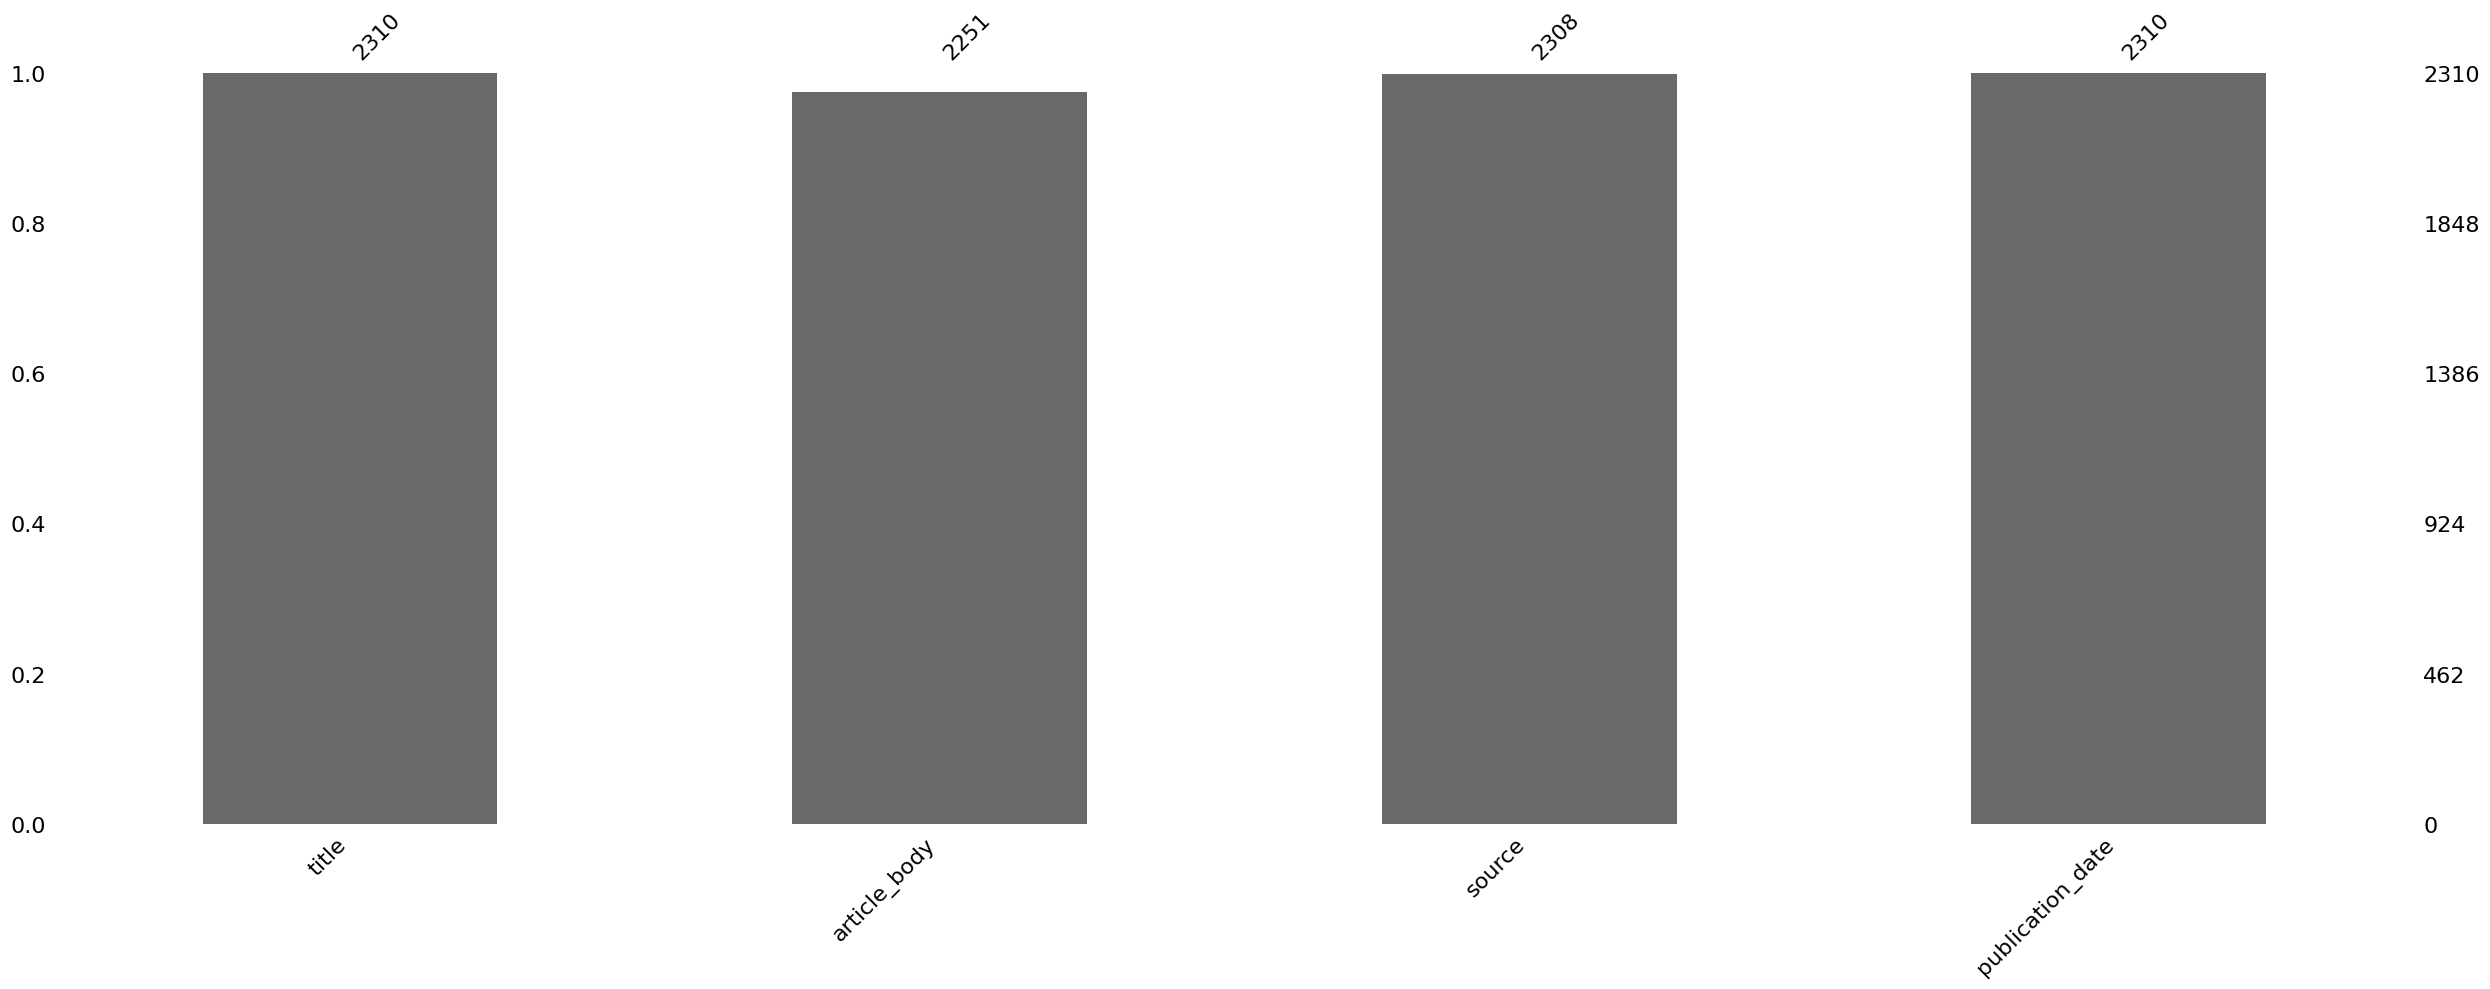

In [38]:
# Concatenate the datasets into a single consolidated dataframe
df = pd.concat([raw_data1, raw_data2], axis=0)

# Remove duplicates
df = df.drop_duplicates()

# Drop NAs
import missingno as msno
msno.bar(df)

df = df[df['article_body'].notna()]


In [39]:
print("Final dataset dimensions are:", df.shape)
df.head(3)

Final dataset dimensions are: (2251, 4)


,title,article_body,source,publication_date
0,"Jail for man who hurled vulgarities, racially ...","During a taxi ride last year, a passenger hurl...",The Straits Times (Singapore),26-08-2021
1,"Jailed for break-in, hurting woman out of jeal...",Angry that the woman he had feelings for could...,The Straits Times (Singapore),26-08-2021
2,"To fight lymphoma, cancer patient first in Sin...",SINGAPORE - Cycling enthusiast Sam Tan used to...,Today (Singapore) - Online,28-08-2021


##### 3. Use SpaCy for language detection

In [40]:
# Use SpaCy Language Models to detect language
# !pip install -U spacy
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

def spacy_language_detection(text):
      
      def get_lang_detector(nlp, name):
            return LanguageDetector()
  
      nlp = spacy.load("en_core_web_sm")
      Language.factory("language_detector", func=get_lang_detector)
      nlp.add_pipe('language_detector', last=True)
      doc = nlp(text)
      return doc._.language


In [41]:
# Analyse dataset articles for language filtering scores by applying SpaCy Language Detection
df["lang_detection"] = df["article_body"].apply(lambda x: spacy_language_detection(x))

# Create new features for language detected and probability scores
df["lang"] = df["lang_detection"].apply(lambda x: x["language"])
df["score"] = df["lang_detection"].apply(lambda x: x["score"])

df.head(3) # Check dataframe

In [42]:
# Export the cleaned dataframe for future use
df.to_csv("./data/df_cleaned.csv")

In [43]:
# Load_clean df
df = pd.read_csv("./data/combined_df_cleaned.csv", index_col=0)

# Check for language distribution as a percentage
print(((df.groupby(["lang"])["title"].count()/len(df.index))*100).sort_values(ascending=False).head(15))

lang
en         85.828521
zh-cn       6.175033
id          2.754331
UNKNOWN     0.710795
tl          0.577521
nl          0.488672
it          0.444247
de          0.399822
fr          0.310973
ca          0.310973
no          0.266548
af          0.222124
so          0.222124
ro          0.177699
et          0.133274
Name: title, dtype: float64


In [45]:
# Check some instances of foreign languages - Unknown language
df[df["lang"]=="UNKNOWN"].head()
# These appear to be mainly URL links that can be discarded

,title,article_body,source,publication_date,lang_detection,lang,score
183,https://t.me/+Vfhed-8zGUhjYTA0,https://t.me/+Vfhed-8zGUhjYTA0,facebook.com,22-06-2022,"{'language': 'UNKNOWN', 'score': 0.0}",UNKNOWN,0.0
260,https://t.me/+2eKIwjVdfs00Nzg8,https://t.me/+2eKIwjVdfs00Nzg8,facebook.com,28-06-2022,"{'language': 'UNKNOWN', 'score': 0.0}",UNKNOWN,0.0
300,"<a href=""https://www.facebook.com/106738085275...",https://www.facebook.com/106738085275012/posts...,facebook.com,18-05-2022,"{'language': 'UNKNOWN', 'score': 0.0}",UNKNOWN,0.0
775,:+1:,:+1:,facebook.com,06-05-2022,"{'language': 'UNKNOWN', 'score': 0.0}",UNKNOWN,0.0
884,:+1:,:+1:,facebook.com,17-05-2022,"{'language': 'UNKNOWN', 'score': 0.0}",UNKNOWN,0.0


In [46]:
df[df["lang"]=="de"].head()
# These include genuine articles from German sources but also mis-identified articles

,title,article_body,source,publication_date,lang_detection,lang,score
127,THE SINGAPORE GENERAL HOSPITAL WAS UNDERING BU...,THE SINGAPORE GENERAL HOSPITAL WAS UNDERING BU...,facebook.com,17-06-2022,"{'language': 'de', 'score': 0.5714275963101858}",de,0.571428
486,Karen Humphreys,Karen Humphreys,facebook.com,02-06-2022,"{'language': 'de', 'score': 0.9999955099255772}",de,0.999996
529,Tine Tine Mendoza,Tine Tine Mendoza,facebook.com,05-06-2022,"{'language': 'de', 'score': 0.9999959510539955}",de,0.999996
994,"FIXED MATCHES AVAILABLE <a href=""\nhttps://t.m...",FIXED MATCHES AVAILABLE \nhttps://t.me/chrisja...,facebook.com,05-04-2022,"{'language': 'de', 'score': 0.7184707726145794}",de,0.718471
1231,"SingHealth, NSCC und NVIDIA schließen sich für...","SingHealth, das National Supercomputing Centre...",germanic.news,02-03-2022,"{'language': 'de', 'score': 0.9999976338011074}",de,0.999998


In [47]:
df[df["lang"]=="it"].head()
# The italian-identified articles seem to be mis-identified, as well as include emoticons denoted by the (:emoji:) format.

,title,article_body,source,publication_date,lang_detection,lang,score
190,Congratulations Nurse Loke\n:bouquet::bouquet:...,Congratulations Nurse Loke\n:bouquet::bouquet:...,facebook.com,23-06-2022,"{'language': 'it', 'score': 0.5714259965036369}",it,0.571426
272,ConGratz Aini. Well done.,ConGratz Aini. Well done.,facebook.com,29-06-2022,"{'language': 'it', 'score': 0.8571386478293118}",it,0.857139
288,Congratulations hazziq,Congratulations hazziq,facebook.com,30-06-2022,"{'language': 'it', 'score': 0.42857142134954945}",it,0.428571
643,SGH (Singapore General Hospital),SGH (Singapore General Hospital),asiaone.com,25-04-2022,"{'language': 'it', 'score': 0.9999943108971996}",it,0.999994
647,Dorscon,Dorscon,facebook.com,26-04-2022,"{'language': 'it', 'score': 0.9999956824742557}",it,0.999996


In [48]:
# Keep only english-language articles
df_eng = df[df["lang"]=="en"]
df_eng.reset_index(drop=True, inplace=True)

##### 4. EDA

In [49]:
!pip install cufflinks
import cufflinks as cf # Cufflinks is a very useful add-on to plot figures directly from the dataframe series object

cf.go_offline()

def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [50]:
df_eng_top20sources = df_eng['source'].value_counts().head(20)

In [51]:
# Visualise the length of the article bodies
df_eng["article_length"] = df_eng["article_body"].apply(lambda x: len(x))
df_eng["summary_length"] = df_eng["title"].apply(lambda x: len(x))
df_eng.head(3)

,title,article_body,source,publication_date,lang_detection,lang,score,article_length,summary_length
0,"Jail for man who hurled vulgarities, racially ...","During a taxi ride last year, a passenger hurl...",The Straits Times (Singapore),26-08-2021,"{'language': 'en', 'score': 0.9999970253802478}",en,0.999997,2032,121
1,"Jailed for break-in, hurting woman out of jeal...",Angry that the woman he had feelings for could...,The Straits Times (Singapore),26-08-2021,"{'language': 'en', 'score': 0.9999957489983977}",en,0.999996,2911,201
2,"To fight lymphoma, cancer patient first in Sin...",SINGAPORE - Cycling enthusiast Sam Tan used to...,Today (Singapore) - Online,28-08-2021,"{'language': 'en', 'score': 0.9999973622633453}",en,0.999997,9178,165


count     1932.000000
mean       882.507246
std       1948.432703
min          7.000000
25%        145.000000
50%        152.000000
75%        619.750000
max      32767.000000
Name: article_length, dtype: float64


<AxesSubplot:xlabel='article_length', ylabel='Count'>

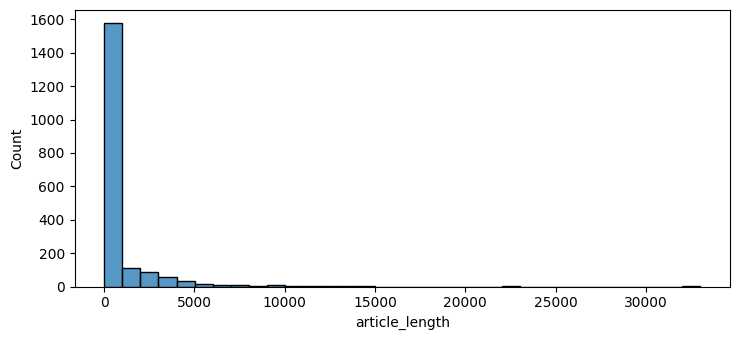

In [52]:
# Check data spread of media article lengths
import seaborn as sns

print(df_eng["article_length"].describe())
sns.histplot(data=df_eng, x="article_length", binwidth=1000)

count     1932.000000
mean       106.899068
std        363.137615
min          6.000000
25%         67.000000
50%        104.000000
75%        111.000000
max      11365.000000
Name: summary_length, dtype: float64


<AxesSubplot:xlabel='summary_length', ylabel='Count'>

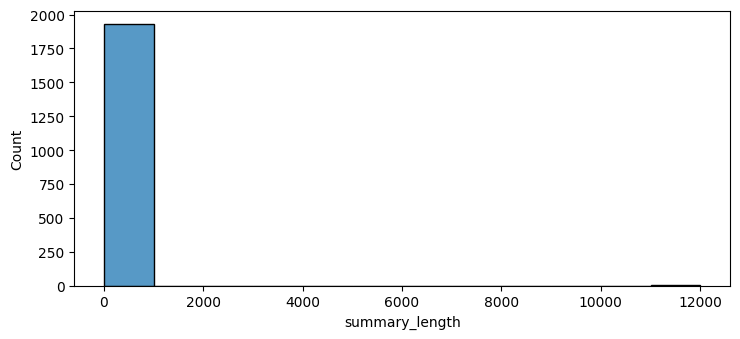

In [53]:
print(df_eng["summary_length"].describe())
sns.histplot(data=df_eng, x="summary_length", binwidth=1000)

In [54]:
# Visualise the length of the article bodies
# !pip install nbformat
configure_plotly_browser_state()

df_eng["article_length"].iplot(kind='hist', bins=100, xTitle='Article Body Length', linecolor='black', yTitle='count', title='Media Source Distribution')

In [55]:
# Visualise the distribution of the top 20 english-language article sources 
# !pip install nbformat
configure_plotly_browser_state()

df_eng_top20sources.iplot(kind='bar', bins=20, xTitle='Media Sources', linecolor='black', yTitle='count', title='Media Source Distribution')

##### 5. Further text processing and rare words removal

In [56]:
# NLTK word frequency
# !pip install nltk
import nltk
import string

# from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Data cleaning
def data_cleaner(text):
    PUNCT_TO_REMOVE = string.punctuation

    stemmer = PorterStemmer()
    text = text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
    text = text.lower().split() # lowercase all text    
    text = [word for word in text if word not in set(stopwords.words('english')+ ["patient", "said", "sgh", "take", "use", "help"])] # Remove stopwords
    text = [word for word in text if not word.isdigit()]
    text = [stemmer.stem(word) for word in text]
    return " ".join(text)

df_eng['article_body'] = df_eng['article_body'].apply(lambda x: data_cleaner(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ervin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
# Check most frequent words 
from collections import Counter

most_cnt = Counter()
for text in df_eng["article_body"].values:
    for word in text.split():
        most_cnt[word] += 1
        
most_cnt.most_common(20)

[('singapor', 2158),
 ('hospit', 1716),
 ('gener', 890),
 ('year', 844),
 ('patient', 823),
 ('also', 810),
 ('mr', 740),
 ('one', 671),
 ('covid19', 611),
 ('time', 608),
 ('peopl', 561),
 ('care', 538),
 ('dr', 534),
 ('medic', 526),
 ('health', 514),
 ('two', 500),
 ('healthcar', 489),
 ('work', 479),
 ('fire', 479),
 ('nation', 467)]

In [58]:
def remove_freq_words(text):

    # Top 20 most frequent words
    FREQWORDS = set([w.lower() for (w, wc) in most_cnt.most_common(20)])

    text = text.lower().split() # lowercase all text
    text = [word for word in text if word not in FREQWORDS]
    text = " ".join(text)
    return text

df_eng['article_body'] = df_eng['article_body'].apply(lambda x: remove_freq_words(x))

In [59]:
# Check least frequent words 
from collections import Counter

least_cnt = Counter()

for text in df_eng["article_body"].values:
    for word in text.split():
        least_cnt[word] += 1
        
list(reversed(least_cnt.most_common(20)))

[('home', 314),
 ('vaccin', 317),
 ('unit', 322),
 ('get', 328),
 ('worker', 333),
 ('could', 334),
 ('nurs', 337),
 ('need', 345),
 ('treatment', 346),
 ('public', 359),
 ('ad', 367),
 ('would', 369),
 ('tan', 376),
 ('last', 383),
 ('case', 395),
 ('may', 401),
 ('cancer', 430),
 ('day', 431),
 ('new', 443),
 ('ms', 465)]

In [60]:
def remove_leastfreq_words(text):

    # Top 20 most frequent words
    RAREWORDS = set([w for (w, wc) in reversed(least_cnt.most_common(20))])

    text = text.lower().split() # lowercase all text
    text = [word for word in text if word not in RAREWORDS]
    text = " ".join(text)
    return text

df_eng['article_body'] = df_eng['article_body'].apply(lambda x: remove_leastfreq_words(x))

##### 6. N-gram frequency and WordCloud Analysis

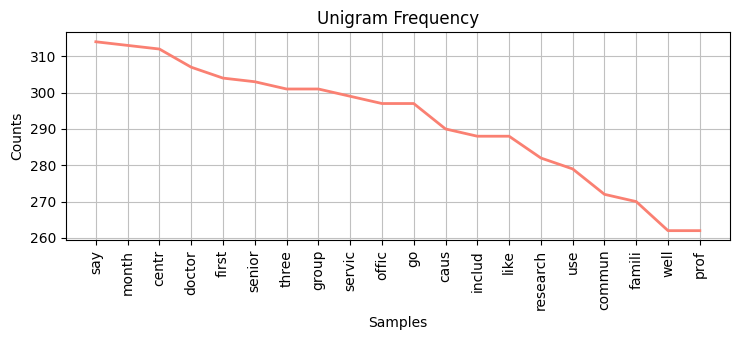

In [61]:
all_words=[]        
for i in range(len(df_eng['article_body'].values)):
    all_words += df_eng['article_body'][i].split()

# Visualise word frequency for unigrams        
nlp_words = nltk.FreqDist(all_words)
unigram = nlp_words.plot(20, color='salmon', title='Unigram Frequency')

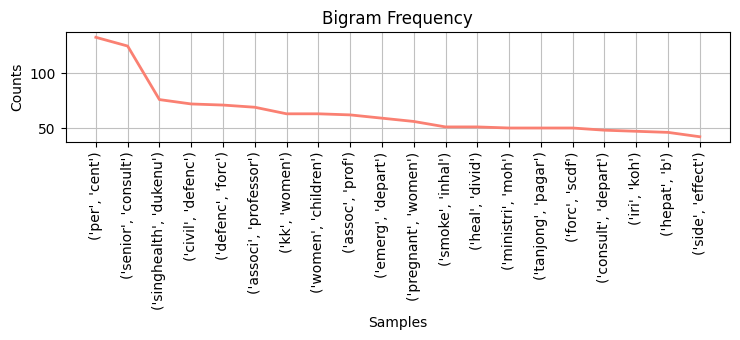

<AxesSubplot:title={'center':'Bigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [62]:
import nltk
from nltk.collocations import *

# Visualise word frequency for bigrams  
bigram = list(nltk.bigrams(all_words))
words_2 = nltk.FreqDist(bigram)
words_2.plot(20, color='salmon', title='Bigram Frequency')

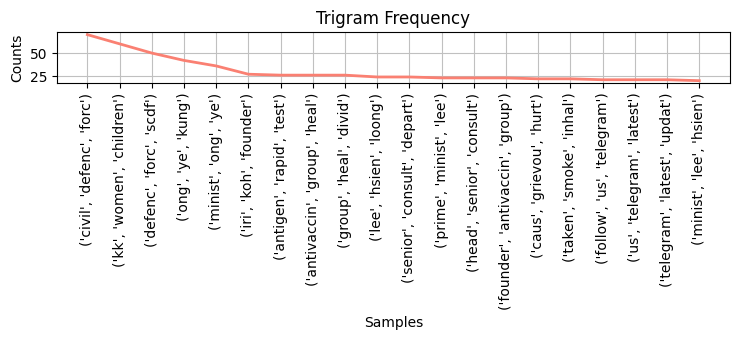

<AxesSubplot:title={'center':'Trigram Frequency'}, xlabel='Samples', ylabel='Counts'>

In [63]:
# Visualise word frequency for trigrams
trigram = list(nltk.trigrams(all_words))
words_2 = nltk.FreqDist(trigram)
words_2.plot(20, color='salmon', title='Trigram Frequency')


[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: python.exe -m pip install --upgrade pip


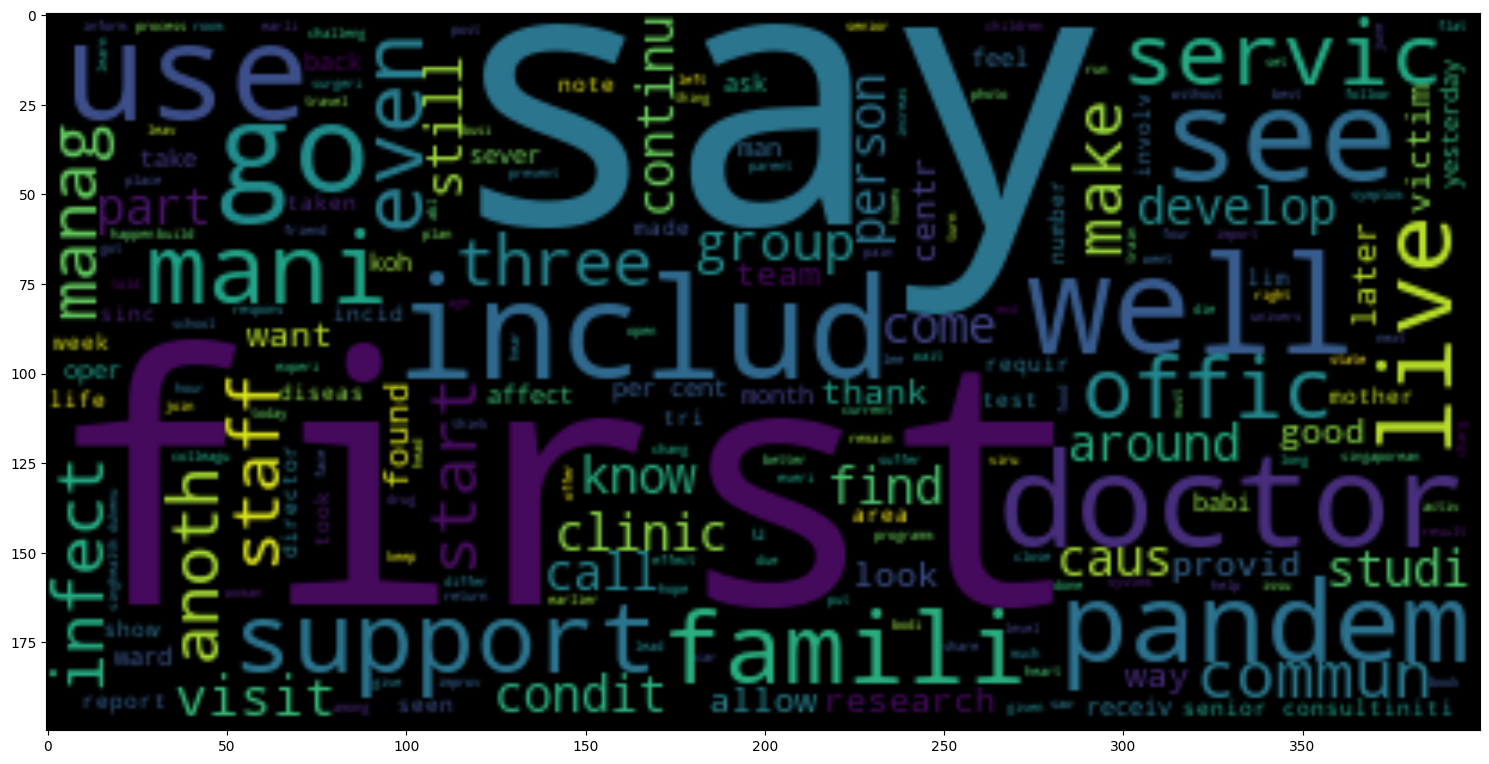

In [64]:
# Visualize Word Cloud
!pip install wordcloud

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud_before = WordCloud().generate(' '.join(df_eng['article_body']))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud_before, interpolation='bilinear')

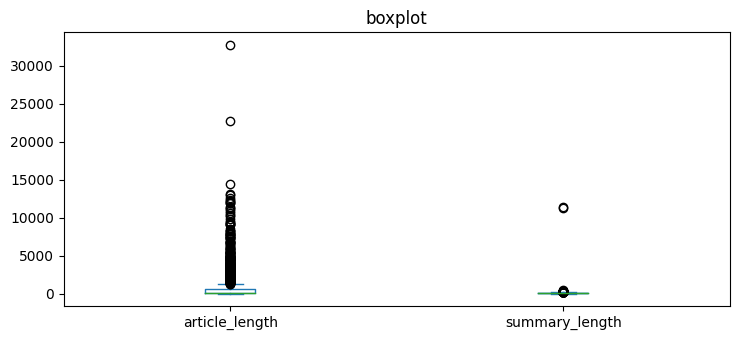

In [65]:
import matplotlib.pyplot as plt

# Set the figure size
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

# Plot the dataframe
ax = df_eng[['article_length', 'summary_length']].plot(kind='box', title='boxplot')

# Display the plot
plt.show()

In [66]:
import numpy as np

# First quartile (Q1)
ArtLenQ1 = np.quantile(df_eng['article_length'], 0.25)

# Median (Q2)

ArtLenQ2 = np.quantile(df_eng['article_length'], 0.5)
  
# Third quartile (Q3)
ArtLenQ3 = np.quantile(df_eng['article_length'], 0.75)

# Fourth quartile (Q3)
ArtLenQ4 = np.quantile(df_eng['article_length'], 1.00)
  
# Interquaritle range (IQR)
ArtLenIQR = ArtLenQ3 - ArtLenQ1

ArtLen_lower_range = ArtLenQ1 - 1.5 * ArtLenIQR
ArtLen_upper_range = ArtLenQ3 + 1.5 * ArtLenIQR
ArtLen_outlier_free_list = [x for x in df_eng['article_length'] if ((x > ArtLen_lower_range) & (x < ArtLen_upper_range))]
df_eng = df_eng.loc[df_eng['article_length'].isin(ArtLen_outlier_free_list)]

print("Article Length Q1:", ArtLenQ1, "characters" )
print("Article Length Q2:", ArtLenQ2, "characters" )
print("Article Length Q3:", ArtLenQ3, "characters" )
print("Article Length Q4:", ArtLenQ4, "characters" )
print("Article Length Lower Range:", ArtLen_lower_range, "characters")
print("Article Length Upper Range:", ArtLen_upper_range, "characters")

# First quartile (Q1)
SumLenQ1 = np.quantile(df_eng['summary_length'], 0.25)

# Median (Q2)

SumLenQ2 = np.quantile(df_eng['summary_length'], 0.5)
  
# Third quartile (Q3)
SumLenQ3 = np.quantile(df_eng['summary_length'], 0.75)

# Fourth quartile (Q3)
SumLenQ4 = np.quantile(df_eng['summary_length'], 1.00)
  
# Interquaritle range (IQR)
SumLenIQR = SumLenQ3 - SumLenQ1

SumLen_lower_range = SumLenQ1 - 1.5 * SumLenIQR
SumLen_upper_range = SumLenQ3 + 1.5 * SumLenIQR
SumLen_outlier_free_list = [x for x in df_eng['summary_length'] if ((x > SumLen_lower_range) & (x < SumLen_upper_range))]
df_eng = df_eng.loc[df_eng['summary_length'].isin(SumLen_outlier_free_list)]

print("Summary Length Q1:", SumLenQ1, "characters" )
print("Summary Length Q2:", SumLenQ2, "characters" )
print("Summary Length Q3:", SumLenQ3, "characters" )
print("Summary Length Q4:", SumLenQ4, "characters" )
print("Summary Length Lower Range:", SumLen_lower_range, "characters")
print("Summary Length Upper Range:", SumLen_upper_range, "characters")

Article Length Q1: 145.0 characters
Article Length Q2: 152.0 characters
Article Length Q3: 619.75 characters
Article Length Q4: 32767.0 characters
Article Length Lower Range: -567.125 characters
Article Length Upper Range: 1331.875 characters
Summary Length Q1: 61.0 characters
Summary Length Q2: 100.0 characters
Summary Length Q3: 108.0 characters
Summary Length Q4: 368.0 characters
Summary Length Lower Range: -9.5 characters
Summary Length Upper Range: 178.5 characters
